***<p style="text-align: center;">Preliminary Exam in Advanced Machine Learning and Deep Learning</p>***

**Performed by:** Aquino, Manolito Jr. B. <br>
**Class Code:** CPE 313-CPE32S8 <br>
**Submitted to:** Engr. Roman Richard

**Task Description:**
1. Build and train a CNN model from a scratch.  Apply different regularization techniques and data preprocessing to reduce overfitting.

2.  Plot the training and validation loss and accuracy. The target accuracy is 85 and above.

3.  Use the assigned pre-trained model and fine-tuned it. 

4. Build and train a CNN model using the modified pretrained model.

5. Plot the training and validation loss and accuracy. The target accuracy is 95 and above.

6. Use the classification report, confusion matrix and ROC over AUC metric to evaluate also the performance of the scratch and using pre-trained mode

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras.applications import DenseNet121, VGG16

# First Approach

Read the csv file downloaded, make a new column that indicates the file path of the corresponding image

In [3]:
IMAGE_PATH = {os.path.basename(x): x for x in 
        glob(os.path.join('input', 'images*', '*', '*.png'))}

df = pd.read_csv('input\Data_Entry_2017.csv')
df['Path'] = df['Image Index'].map(IMAGE_PATH.get)
df.dtypes


Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
Path                            object
dtype: object

One hot encode the Finding Label values since some findings have multiple disease.

In [4]:
from itertools import chain
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if x != 'No Finding']
print('All Labels ({}): {}'.format(len(labels), labels))

for c_label in labels:
    df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
len(df.columns)

27

Split the data into train, and test values

In [6]:
train_df, test_df = train_test_split(df, test_size = 0.25, random_state = 42, stratify = df['Finding Labels'].map(lambda x: x[:4]))

Declare the callback function we'll be using for training later

In [7]:
early_stop = EarlyStopping(monitor='binary_accuracy', patience= 2)
t_board = TensorBoard(log_dir='logs')

Use image data generator to extract the values of images that we could use for training and fitting the model.

In [8]:

core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

traingen = core_idg.flow_from_dataframe(train_df, directory=None, x_col = 'Path', y_col = train_df.columns[-14:], class_mode = 'raw', target_size = (224, 224), color_mode = 'grayscale', batch_size = 32)

testgen = core_idg.flow_from_dataframe(test_df, directory=None, x_col = 'Path', y_col = train_df.columns[-14:],  class_mode = 'raw', target_size = (224, 224), color_mode = 'grayscale', batch_size = 256)

X_test, y_test = next(core_idg.flow_from_dataframe(test_df, directory=None, x_col = 'Path', y_col = train_df.columns[-14:],
                                              class_mode = 'raw', target_size = (224,224),
                                              color_mode = 'grayscale', batch_size = 1024))

X_train, y_train = next(traingen)


Found 84090 validated image filenames.
Found 28030 validated image filenames.
Found 28030 validated image filenames.


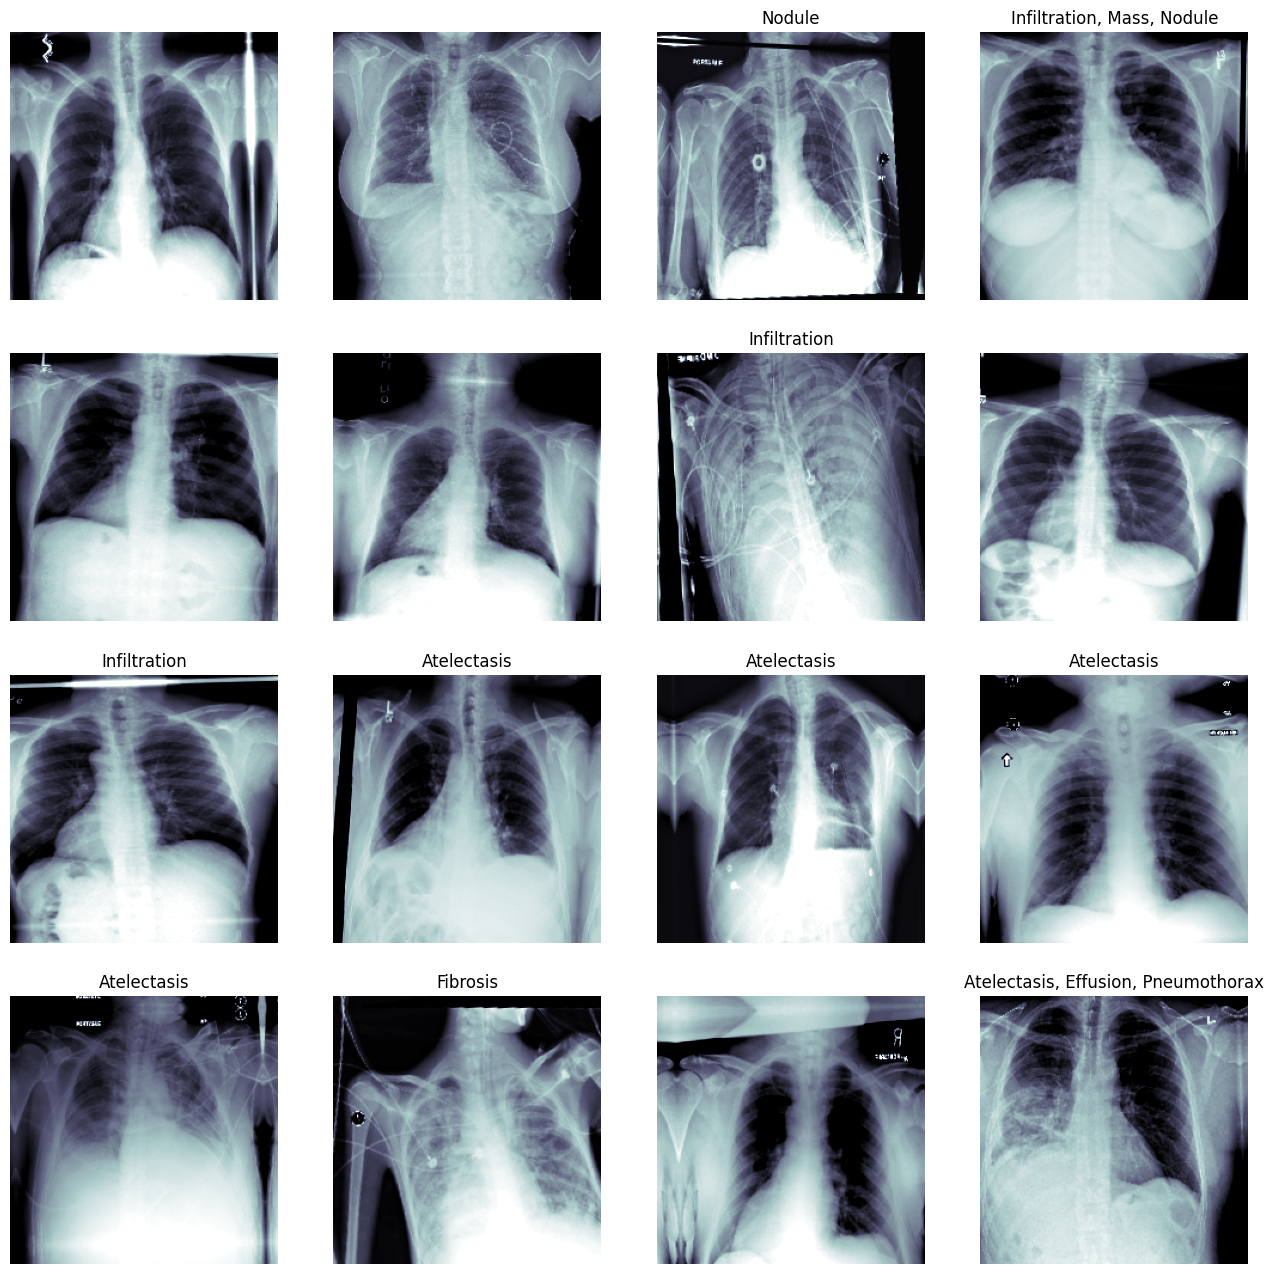

In [9]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(X_train, y_train, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

Model Creation from scratch

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Create CNN model
# Will use a combination of convolutional, max pooling, and dropout layers for this purpose
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 3))
model.add(Dropout(0.2))

# add in fully connected dense layers to model, then output classifiction probabilities using a softmax activation function
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.30))
model.add(Dense(len(labels), activation = 'sigmoid'))

# compile model, run summary
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 16)        0

In [11]:
model.compile(
    optimizer = Adam(learning_rate = 0.0005),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [12]:
hist1 = model.fit(traingen, steps_per_epoch = 50, epochs = 10, validation_data=(X_test, y_test), verbose= 1, callbacks= [early_stop, t_board])

Epoch 1/10
50/50 [==============================] - 27s 452ms/step - loss: 0.2140 - binary_accuracy: 0.9371 - val_loss: 0.4193 - val_binary_accuracy: 0.9491
Epoch 2/10
50/50 [==============================] - 23s 454ms/step - loss: 0.1990 - binary_accuracy: 0.9454 - val_loss: 0.3865 - val_binary_accuracy: 0.9491
Epoch 3/10
50/50 [==============================] - 23s 450ms/step - loss: 0.1889 - binary_accuracy: 0.9488 - val_loss: 0.3302 - val_binary_accuracy: 0.9491
Epoch 4/10
50/50 [==============================] - 23s 462ms/step - loss: 0.1950 - binary_accuracy: 0.9447 - val_loss: 0.3131 - val_binary_accuracy: 0.9491
Epoch 5/10
50/50 [==============================] - 23s 458ms/step - loss: 0.1979 - binary_accuracy: 0.9434 - val_loss: 0.3127 - val_binary_accuracy: 0.9491


Helper function

In [13]:
def plot_hist(history_dict):
    history_dict = history_dict.history
    plt.figure(figsize=(8, 6))
    plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

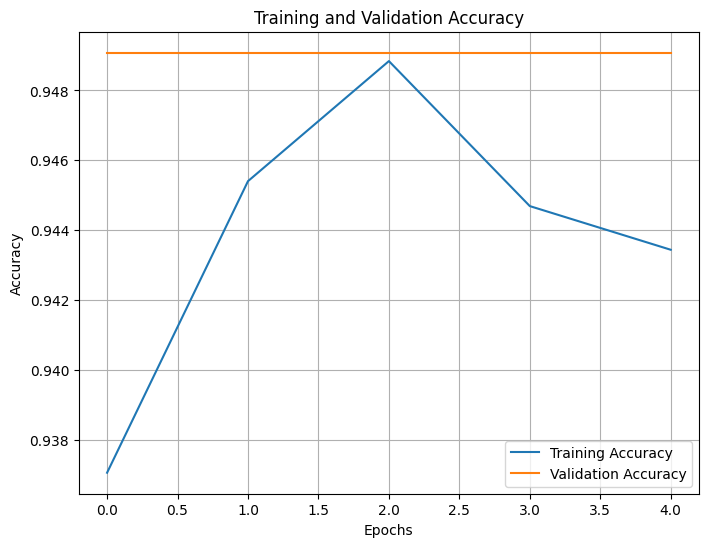

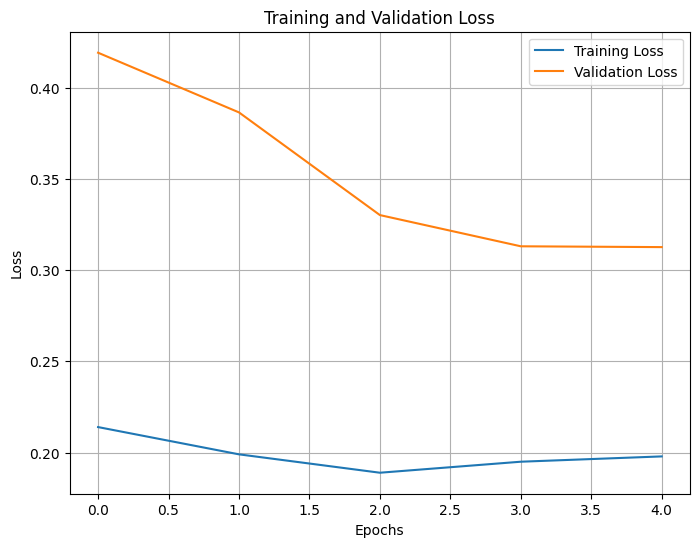

In [14]:
plot_hist(hist1)

In [15]:
pred_Y = model.predict(X_test, batch_size = 64)

16/16 [==============================] - 1s 22ms/step


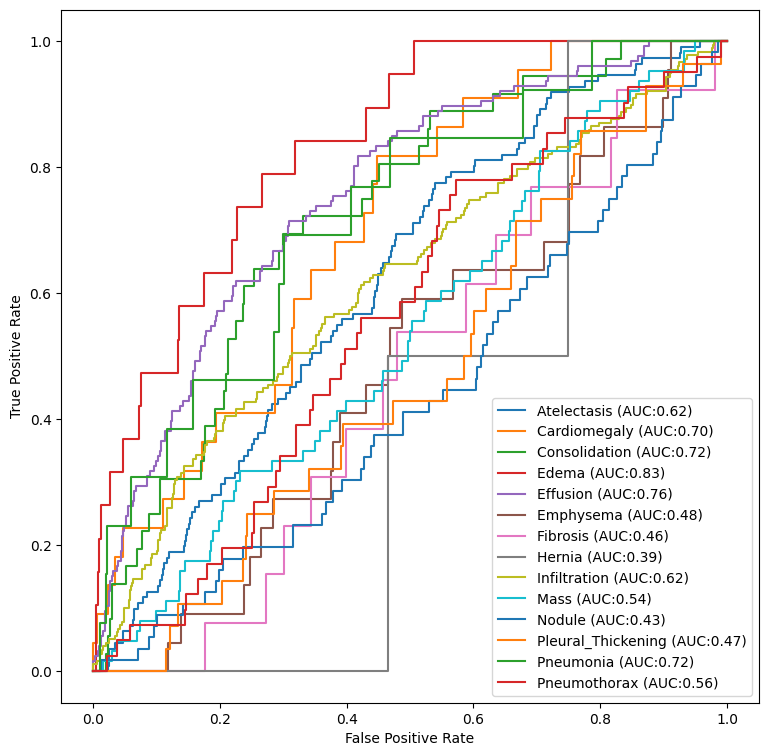

In [16]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')



We can see here that the values for the roc curve of the different diseases have high range of difference, some reaches up to 78 and one goes as low as 41. This is because the distribution of the number of sample for each class is not equal

# New approach

Since we're only getting high binary accuracy for multilable classification, let's try looking at this in a different way. Let's make a deep learning model that classifies if there's a complication with the xray or not.

In [16]:
binarydf = pd.read_csv('input\Data_Entry_2017.csv')
binarydf['Finding Labels'] = binarydf['Finding Labels'].apply(lambda x: 'With Disease' if x != 'No Finding' else 'Without Disease')
binarydf['Finding Labels'].value_counts()

Finding Labels
Without Disease    60361
With Disease       51759
Name: count, dtype: int64

In [17]:
binarydf['Image Index'] = binarydf['Image Index'].map(IMAGE_PATH.get)
binarydf = binarydf[['Image Index', 'Finding Labels']]

In [18]:
majorityclass = binarydf[binarydf['Finding Labels'] == 'Without Disease']
minorityclass = binarydf[binarydf['Finding Labels'] == 'With Disease']

downsample_majority =resample(majorityclass,
                                replace = False,
                                n_samples = len(minorityclass),
                                random_state = 42)
downsampled_df = pd.concat([downsample_majority, minorityclass])
downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
downsampled_df['Finding Labels'].value_counts()


Finding Labels
Without Disease    51759
With Disease       51759
Name: count, dtype: int64

In [19]:
bin_train, bin_test = train_test_split(downsampled_df, test_size= 0.3, shuffle= True, random_state = 25)


In [52]:
bin_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

bin_train_gen = bin_idg.flow_from_dataframe(
    bin_train,
    x_col= 'Image Index',
    y_col= 'Finding Labels',
    batch_size= 32,
    target_size= (224, 224),
    class_mode= 'binary',
)

bin_test_gen = bin_idg.flow_from_dataframe(
    bin_test,
    x_col = 'Image Index',
    y_col= 'Finding Labels',
    batch_size= 32,
    target_size= (224, 224),
    class_mode= 'binary',
)
bin_X_test, bin_y_test = next(bin_idg.flow_from_dataframe(bin_test, directory=None, x_col = 'Image Index', y_col = 'Finding Labels',
                                              class_mode = 'binary', target_size = (224,224),
                                              batch_size = 1024))

bin_X_train, bin_y_train = next(bin_train_gen)


Found 72462 validated image filenames belonging to 2 classes.
Found 31056 validated image filenames belonging to 2 classes.
Found 31056 validated image filenames belonging to 2 classes.


In [53]:
# Create CNN bin_model
# Will use a combination of convolutional, max pooling, and dropout layers for this purpose
bin_model = Sequential()

bin_model.add(Conv2D(filters = 8, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = bin_X_train.shape[1:]))
bin_model.add(MaxPooling2D(pool_size = 2))
bin_model.add(Dropout(0.2))

bin_model.add(Conv2D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
bin_model.add(MaxPooling2D(pool_size = 2))
bin_model.add(Dropout(0.2))
          
bin_model.add(Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu'))
bin_model.add(MaxPooling2D(pool_size = 2))
bin_model.add(Dropout(0.2))

bin_model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
bin_model.add(MaxPooling2D(pool_size = 2))
bin_model.add(Dropout(0.2))
          
bin_model.add(Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
bin_model.add(MaxPooling2D(pool_size = 3))
bin_model.add(Dropout(0.2))

# add in fully connected dense layers to bin_model, then output classifiction probabilities using a softmax activation function
bin_model.add(Flatten())
bin_model.add(Dense(512, activation = 'relu'))
bin_model.add(Dropout(0.30))
bin_model.add(Dense(1, activation = 'sigmoid'))

# compile bin_model, run summary
bin_model.compile(optimizer=Adam(learning_rate = 0.0005), loss='binary_crossentropy', metrics=['binary_accuracy'])
bin_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 224, 224, 8)       608       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 112, 112, 8)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 112, 112, 16)      3216      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 56, 56, 16)      

In [54]:
bin_hist = bin_model.fit(bin_train_gen, epochs= 10, steps_per_epoch=50, callbacks= [early_stop, t_board], validation_data= (bin_X_test, bin_y_test))

Epoch 1/10
50/50 [==============================] - 39s 751ms/step - loss: 0.6970 - binary_accuracy: 0.5335 - val_loss: 0.6890 - val_binary_accuracy: 0.5732
Epoch 2/10
50/50 [==============================] - 37s 740ms/step - loss: 0.6910 - binary_accuracy: 0.5300 - val_loss: 0.6865 - val_binary_accuracy: 0.5830
Epoch 3/10
50/50 [==============================] - 37s 731ms/step - loss: 0.6857 - binary_accuracy: 0.5494 - val_loss: 0.6850 - val_binary_accuracy: 0.5947
Epoch 4/10
50/50 [==============================] - 35s 707ms/step - loss: 0.6788 - binary_accuracy: 0.5831 - val_loss: 0.6844 - val_binary_accuracy: 0.6006
Epoch 5/10
50/50 [==============================] - 33s 662ms/step - loss: 0.6679 - binary_accuracy: 0.6094 - val_loss: 0.6795 - val_binary_accuracy: 0.6250
Epoch 6/10
50/50 [==============================] - 37s 735ms/step - loss: 0.6641 - binary_accuracy: 0.6150 - val_loss: 0.6604 - val_binary_accuracy: 0.6348
Epoch 7/10
50/50 [==============================] - 34s 68

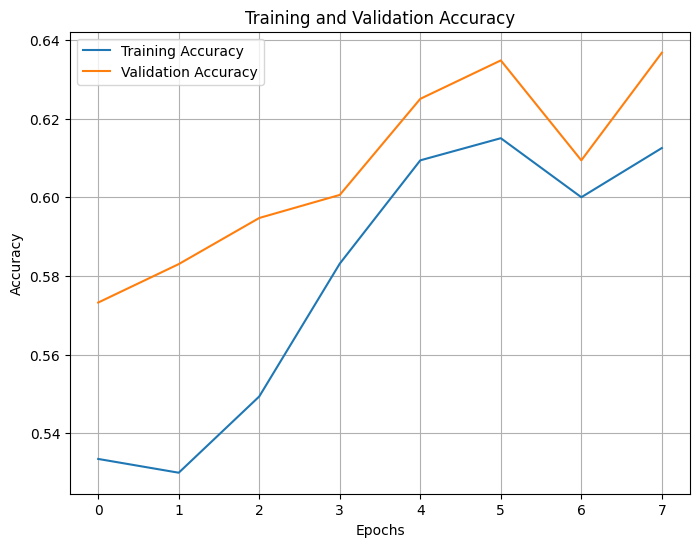

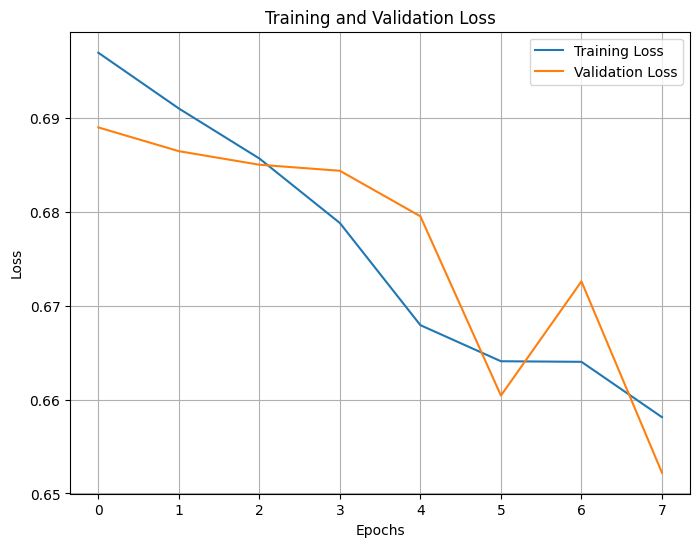

In [55]:
plot_hist(bin_hist)

Here is the fitting history of the model, we can see that it only went up to 63.48 validation accuracy

In [63]:
bin_pred = bin_model.predict(bin_X_test, batch_size = 32)

32/32 [==============================] - 1s 16ms/step


In [69]:
fpr, tpr, _ = roc_curve(bin_y_test, bin_pred)
roc_auc = auc(fpr, tpr)

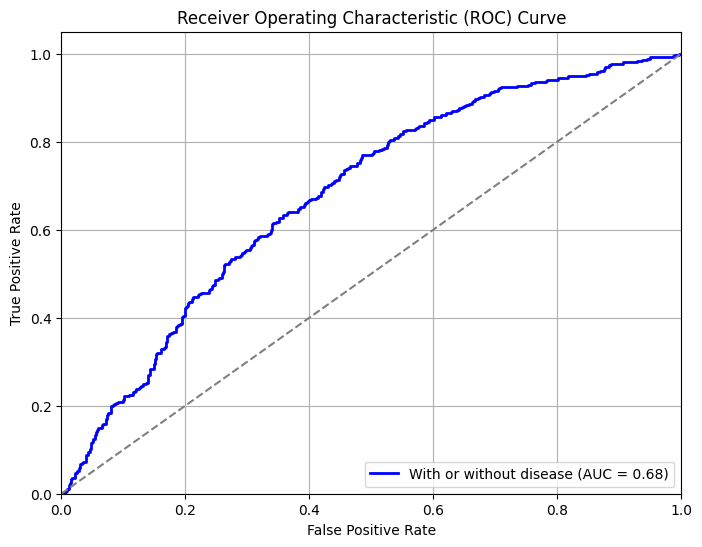

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'With or without disease (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Pre Trained Model

Get the model we've chosen to be the base of our pre trained model

In [9]:
base_model = DenseNet121(weights= None, include_top= False, input_shape= (224, 224, 1))

Freeze the model layers of the base layer too keep the weights it has already stored.

In [10]:
for layer in base_model.layers:
    layer.trainable = False


Fine tune the model and make the output layers that will fit to our desired values. As we can see here, we needed the final layer to be Dense with a value of 14 and activation of sigmoid

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

Combine the base and the created output layer

In [12]:
pre_model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
pre_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
pre_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 conv2_block4_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 56, 56, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
                                                                                                  
 conv2_block5_0_bn (BatchNormal  (None, 56, 56, 192)  768        ['conv2_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block5_0_relu (Activatio  (None, 56, 56, 192)  0          ['conv2_block5_0_bn[0][0]']      
 n)                                                                                               
          

In [14]:
hist2 = pre_model.fit(testgen, epochs = 10, steps_per_epoch= 100, callbacks=[early_stop, t_board], validation_data = (X_test, y_test))

Epoch 1/10
100/100 [==============================] - 1344s 13s/step - loss: 0.2660 - binary_accuracy: 0.9447 - val_loss: 0.1901 - val_binary_accuracy: 0.9468
Epoch 2/10
100/100 [==============================] - 1359s 14s/step - loss: 0.1829 - binary_accuracy: 0.9485 - val_loss: 0.1898 - val_binary_accuracy: 0.9468
Epoch 3/10
100/100 [==============================] - 1355s 14s/step - loss: 0.1825 - binary_accuracy: 0.9486 - val_loss: 0.1898 - val_binary_accuracy: 0.9468
Epoch 4/10
100/100 [==============================] - 1354s 14s/step - loss: 0.1817 - binary_accuracy: 0.9490 - val_loss: 0.1896 - val_binary_accuracy: 0.9468
Epoch 5/10
100/100 [==============================] - 1336s 13s/step - loss: 0.1820 - binary_accuracy: 0.9488 - val_loss: 0.1896 - val_binary_accuracy: 0.9468
Epoch 6/10
100/100 [==============================] - 1299s 13s/step - loss: 0.1823 - binary_accuracy: 0.9487 - val_loss: 0.1900 - val_binary_accuracy: 0.9468


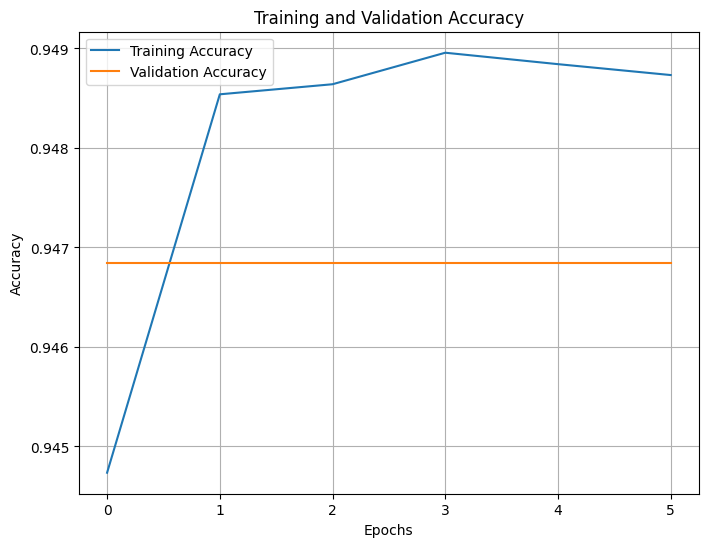

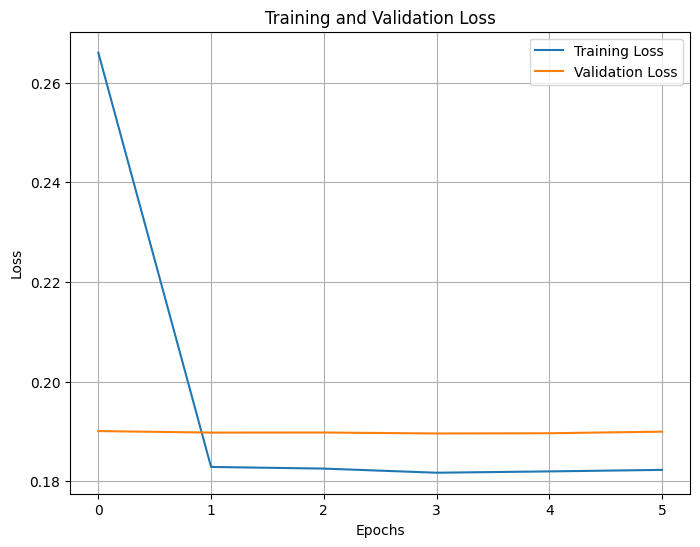

In [17]:
plot_hist(hist2)

In [18]:
premod_pred = pre_model.predict(X_test, batch_size = 32)

32/32 [==============================] - 60s 2s/step


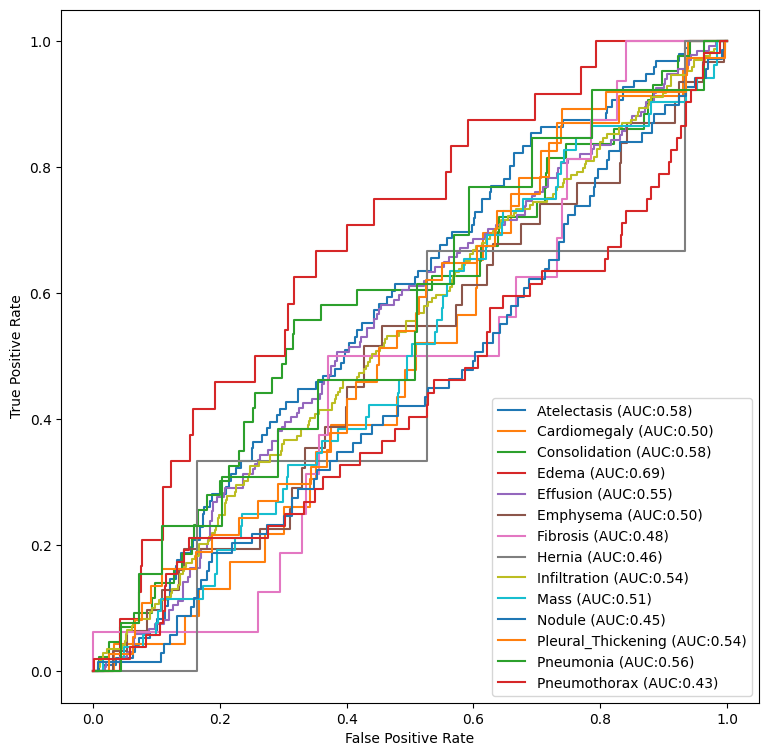

In [19]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), premod_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')



Similar to the result of the earlier model, we can see that some categories such as edema had a auc of 0.69 while pneumothorax only had 0.43. This is due to the data imbalancce present in the dataset we've used

# Conclusion

To summarize this activity I've done that revolves around creating neural networks using the NIH Chest X-ray Dataset. First thing I did is i used ImageDataGenerator to extract features from the dataset I've got. I then created a convolutional neural network model from scratch then trained this model using the earlier dataset I've preprocessed. In creating the neural network, I used the sequential model. I then added different layers such as Conv2D, Dense, MaxPooling2D, and other else. Regularization techniques we're also performed such as dropout. In fitting the dataset, I used callback technique EarlyStopping to prevent unnecessary continuation of training epochs. Although it showed a promising result while training (having high accuracy and low loss), the AUC scores and ROC curve did not. I've only reached as high as 0.71 for a single category and the reason I could think of is that data imbalance really is prevalent in this dataset. 

While making the earlier steps, I realized what if I try making a model that only predicts if a chest x-ray is normal or not (With Disease or Without Disease). I considered this because the ratio of no findings to other labels is close to one is to one. I preprocessed my dataset once again to have the said categorization as y label and same x values. The result is not what I expected. So I abandoned that idea and went back to creating a pretrained model for the earlier approach.

I used DenseNet121 as my base model for the pretrained model, then I've frozen the layers to keep the weights of each layer. I then created the output layer to match my desired output prediction. Afterwards, I combined the base layer's input and my created output layer in order to finalize my pretrained model. Together with the earlier callback technique I created. I then trained my model with the previous data I've preprocessed. Same as how the earlier model performed, it has shown promising accuracy and loss but did not perform well in AUC and ROC.

There are various challenges I've faced in doing this task. First is the amount of data I had to handle. It was at least 40 GB of images, and I was overwhelmed by it. Second is the training of the said dataset really takes time and requires decent hardware specifications. The last challenge and is probably the main issue is still my lack of skills to use ImageDataGenerator or maybe even just handling image data. The first thing I did in order to gain numerical values is I've converted it to NumPy arrays. It led me to many errors and multiple storage issues running it. Then, the issue regarding data types for training my model also occurred.

Overall, this task really did improve my skills and my eagerness to learn more about this course. It was fun spending sleepless nights to debug errors over errors. XD